# Script to create masks using CLIPSeg

Notebook on Colab here: https://colab.research.google.com/drive/1garJqlcwIIkr0maw3tDg57Yi-9km_zN_?usp=sharing

* Before you should upload all the files from the [github](https://github.com/fdelrio89/generative-data-augmentation) 
* When creating the `dataLoader` variable, you can use `debug_load_img` for text as here `dataload = dataLoader(debug_load_img=500)`


In [ ]:
! pip install datasets

qqLooking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os 
import pandas as pd 
import numpy as np
from tqdm import tqdm
from google.colab import files

# Draft dataloader

In [ ]:
from dataloader import dataLoader
dataload = dataLoader()

Text loaded: ['all', 'train_gender']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:02<00:00, 172.62it/s]

Image loaded


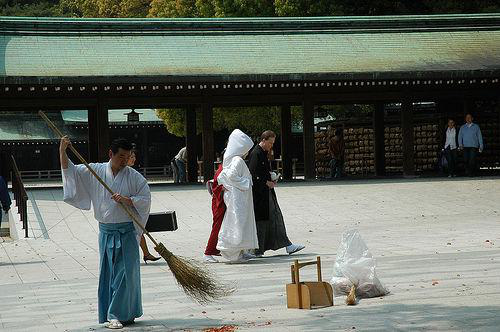

In [ ]:
iid=int(dataload.text_dataset['all'].loc[200, 'image_ID'])
dataload.iid2img(iid)

# Segmentation

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 7.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

import torch
def create_masks(images, prompts):
  """
  Function that return the masks regarding the images and prompts
  input: 
    images: list of images
    prompts: list of textual prompts of the segmentation target 

  output:
    masks: list of boolean masks of size 352*352
  """
  assert len(images) == len(prompts)
  inputs = processor(text=prompts, images=images, padding="max_length", return_tensors="pt")
  # predict
  with torch.no_grad():
    outputs = model(**inputs)
  preds = outputs.logits.unsqueeze(1)
  # create the mask
  if len(images) == 1:
    torch_sigmo = torch.sigmoid(preds[:,0,:]) # ici change car on a qu'un image/prompt
    masks = [(torch_sigmo-torch_sigmo.min())/(torch_sigmo.max()-torch_sigmo.min()) > .1]
  else:
    masks = []
    for n_samp in range(preds.shape[0]):
      torch_sigmo = torch.sigmoid(preds[n_samp][0])
      masks.append((torch_sigmo-torch_sigmo.min())/(torch_sigmo.max()-torch_sigmo.min()) > .1)
  return masks

In [ ]:
# files.upload()
skill = 'gender'
df = dataload.text_dataset['train_%s'%skill]
df.head()

image_ID  caption_ID                                            caption  \
0  1000092795           0  Two young guys with shaggy hair look at their ...   
1  1000092795           2    Two men in green shirts are standing in a yard.   
2  1000092795           3        A man in a blue shirt standing in a garden.   
3    10002456           5  Several men in hard hats are operating a giant...   
4    10002456           7    Two men working on a machine wearing hard hats.   

   split word_detected                                 augmented_captions  \
0  train      ['guys']  ['Two young girls with shaggy hair look at the...   
1  train       ['men']  ['Two women in green shirts are standing in a ...   
2  train       ['man']  ['A woman in a blue shirt standing in a garden.']   
3  train       ['men']  ['Several women in hard hats are operating a g...   
4  train       ['men']  ['Two women working on a machine wearing hard ...   

  prompt_segmentation  
0  ['Two young guys']  
1         ['Two men']  
2           ['A man']  
3     ['Several men']  
4         ['Two men']

In [ ]:
if df.index.name != 'caption_ID':
  df.set_index('caption_ID', drop=False, inplace=True)

# for cid in tqdm(df.head(1).caption_ID.values): # using .head(1) for test only
for cid in tqdm(df.caption_ID.values):
  prompt = df.loc[cid, 'prompt_segmentation'][0]
  #prompts = [prompt]
  iid = df.loc[cid, 'image_ID']
  image = dataload.iid2img(iid)

  masks = create_masks(images=[image]*2, prompts=[prompt]*2)

# Draft, to play

In [ ]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
texts = ["a cat", "a remote", "a blanket"]
inputs = processor(text=texts, images=[image] * len(texts), padding=True, return_tensors="pt")

outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

Downloading:   0%|          | 0.00/380 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/974 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/603M [00:00<?, ?B/s]

torch.Size([3, 352, 352])


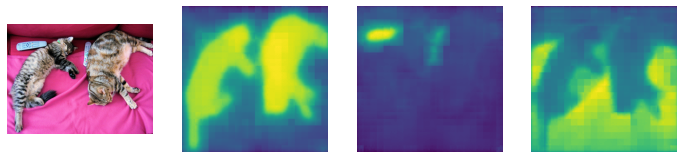

In [ ]:
_, ax = plt.subplots(1, 3 + 1, figsize=(3*(3 + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(logits[i].detach().numpy()) for i in range(3)]

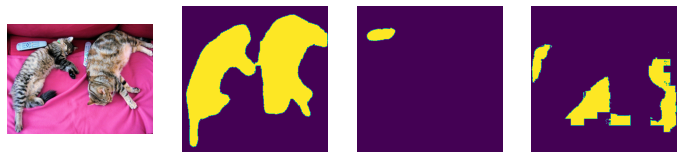

In [ ]:
_, ax = plt.subplots(1, 3 + 1, figsize=(3*(3 + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(outputs.decoder_output[0][i].detach().numpy()>0) for i in range(3)]

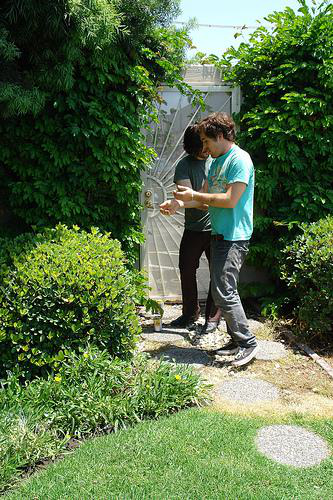

In [ ]:
idx = 0
iid = df.loc[idx, 'image_ID']
capt= df.loc[idx, 'caption']

iid2img[iid]

In [ ]:
df.set_index(['image_ID', 'caption_ID'], drop=False, inplace=True)
df.loc[iid].sample(n=1)

In [ ]:
df.head(5).caption_ID.values

array([0, 2, 3, 5, 7])

In [ ]:
# df.set_index('caption_ID', drop=False, inplace=True)
str2list = lambda x: [k[1:-1] for k in x.strip('][').split(', ')]

for cid in tqdm(df.head(1).caption_ID.values):
  prompt = str2list(df.loc[cid, 'prompt_segmentation'])[0]
  #prompts = [prompt]
  iid = df.loc[cid, 'image_ID']
  image = iid2img[iid]

  masks = create_masks(images=[image]*2, prompts=[prompt]*2)

100%|██████████| 1/1 [00:07<00:00,  7.90s/it]


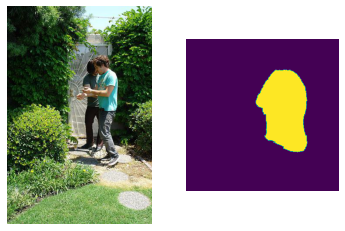

In [ ]:
#imshow(masks[0])
_, ax = plt.subplots(1, 1 + 1, figsize=(3*(1 + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
ax[1].imshow(masks[0])

In [ ]:
for cid in tqdm(df.head(1).caption_ID.values):
  prompt = str2list(df.loc[cid, 'prompt_segmentation'])[0]
  prompts = [prompt]*3
  iid = df.loc[cid, 'image_ID']
  image = iid2img[iid]

  inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
  # predict
  with torch.no_grad():
    outputs = model(**inputs)
  preds = outputs.logits.unsqueeze(1)

100%|██████████| 1/1 [00:15<00:00, 15.87s/it]


In [ ]:
preds.shape

torch.Size([3, 1, 352, 352])

 67%|██████▋   | 20/30 [00:46<00:26,  2.60s/it]<ipython-input-33-4ccb699ce615>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 3 + 1, figsize=(3*(3 + 1), 4))
 70%|███████   | 21/30 [00:48<00:22,  2.47s/it]<ipython-input-33-4ccb699ce615>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 3 + 1, figsize=(3*(3 + 1), 4))
 73%|███████▎  | 22/30 [00:50<00:18,  2.37s/it]<ipython-input-33-4ccb699ce615>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface

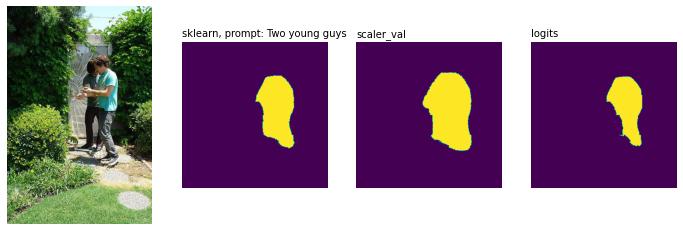

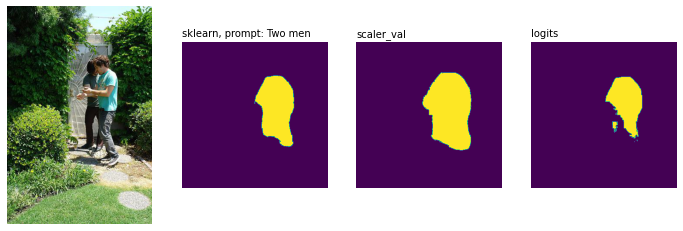

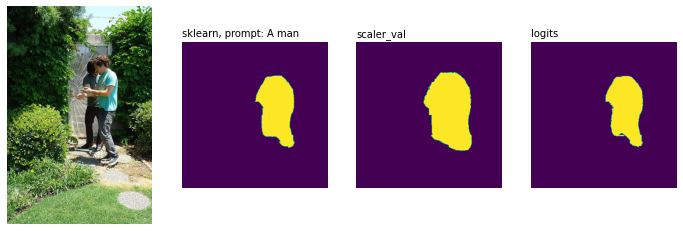

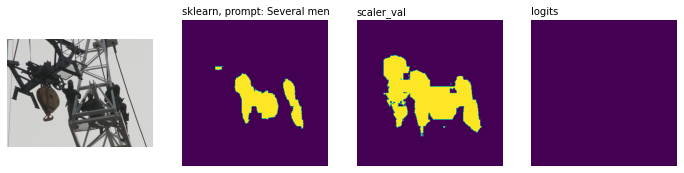

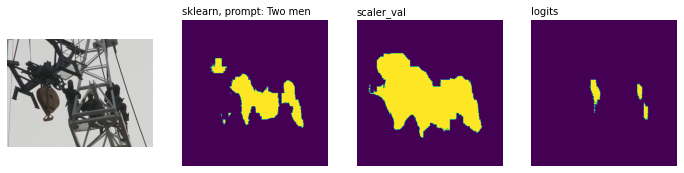

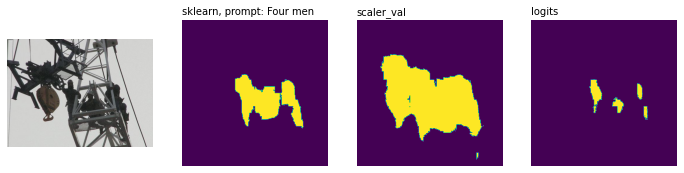

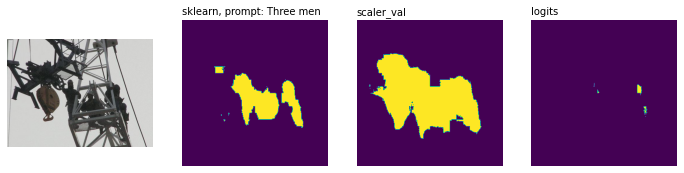

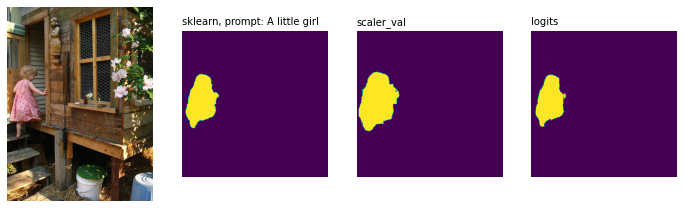

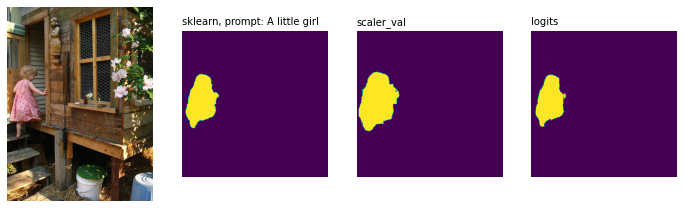

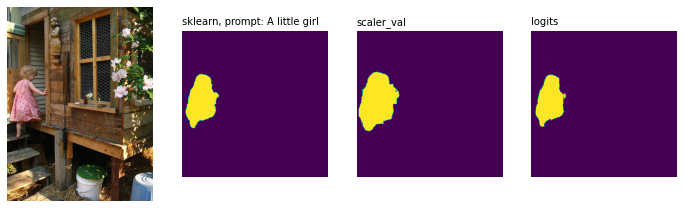

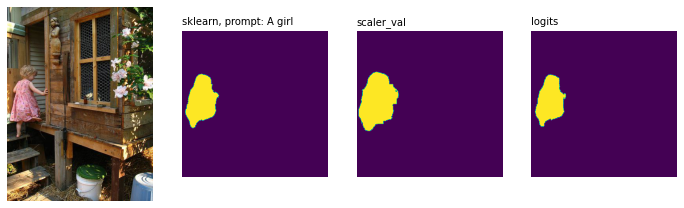

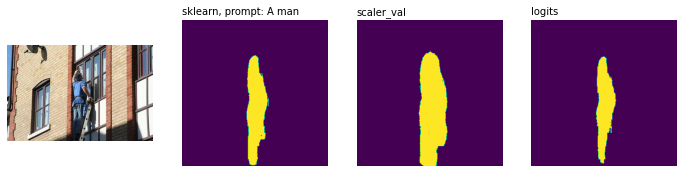

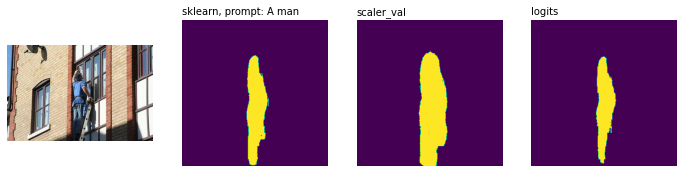

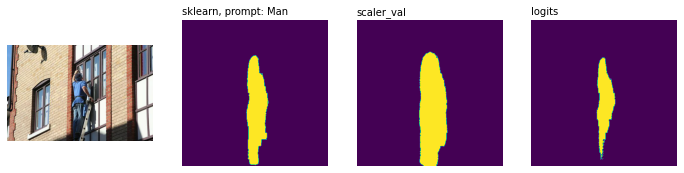

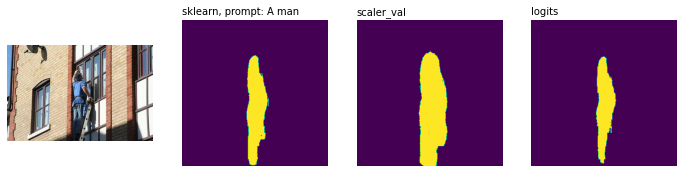

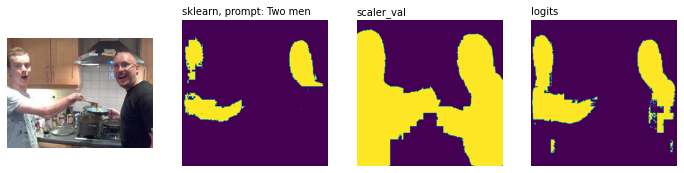

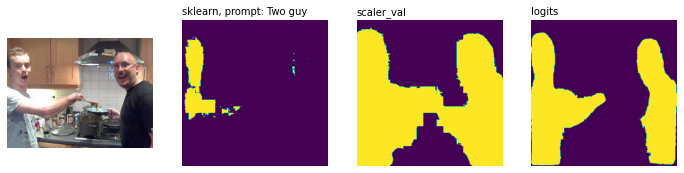

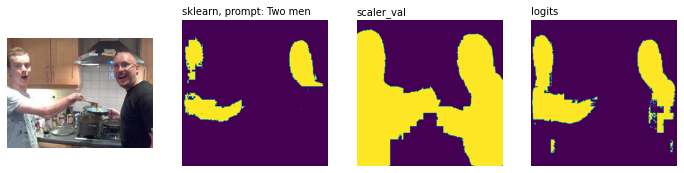

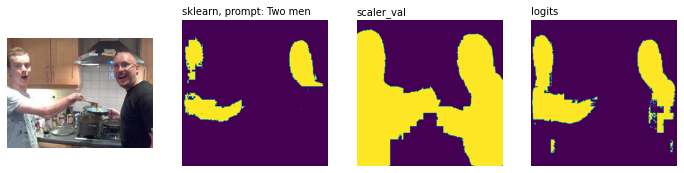

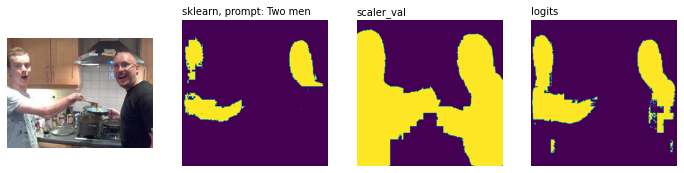

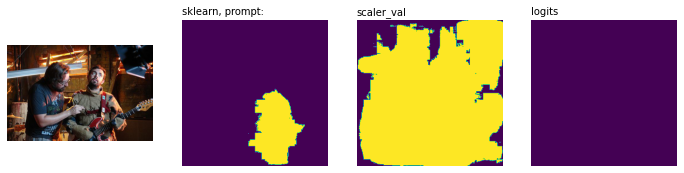

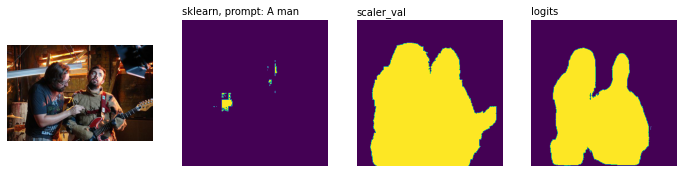

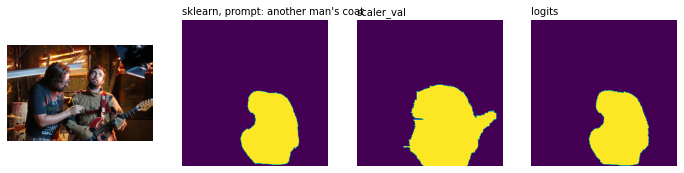

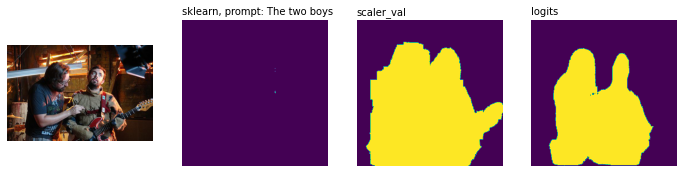

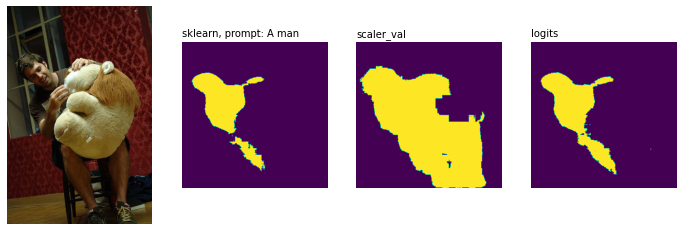

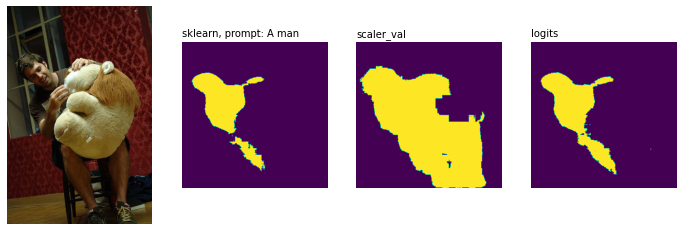

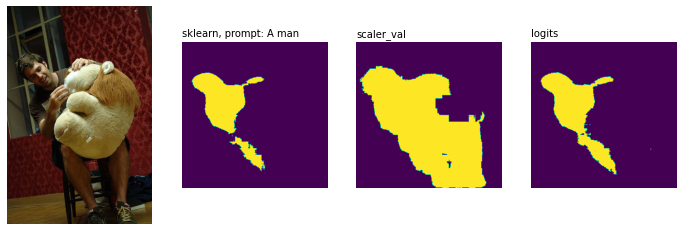

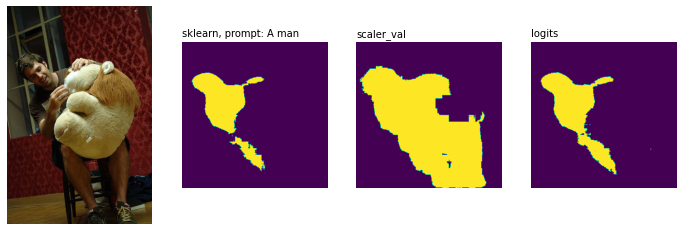

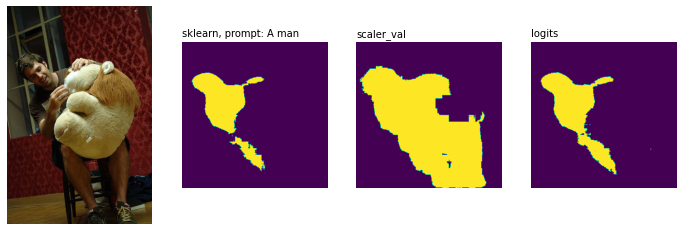

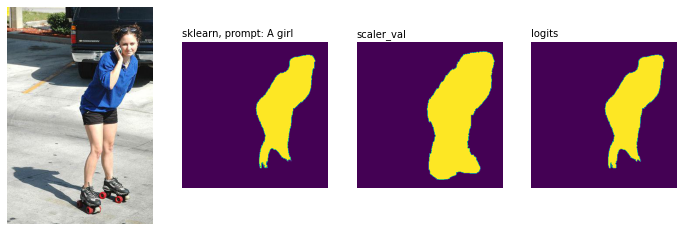

In [ ]:
# df.set_index(['image_ID', 'caption_ID'], drop=False, inplace=True)
df.set_index('caption_ID', drop=False, inplace=True)
str2list = lambda x: [k[1:-1] for k in x.strip('][').split(', ')]
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,Normalizer 
scaler=Normalizer()

for cid in tqdm(df.head(30).caption_ID.values):
  prompt = str2list(df.loc[cid, 'prompt_segmentation'])[0]
  prompts = [prompt]
  iid = df.loc[cid, 'image_ID']
  image = iid2img[iid]

  inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
  # predict
  with torch.no_grad():
    outputs = model(**inputs)
  preds = outputs.logits.unsqueeze(1)

  _, ax = plt.subplots(1, 3 + 1, figsize=(3*(3 + 1), 4))
  [a.axis('off') for a in ax.flatten()]
  ax[0].imshow(image)
  
  torch_sigmo = torch.sigmoid(preds[:,0,:]) # ici change car on a qu'un image/prompt
  n_img = torch_sigmo.shape
  scaler_sklearn = scaler.fit_transform(torch_sigmo.reshape(-1,n_img[0]*n_img[1])).reshape(n_img) > .005
  scaler_val = (torch_sigmo-torch_sigmo.min())/(torch_sigmo.max()-torch_sigmo.min()) > .1
  logits_only = preds[:,0,:] > 0

  [ax[1].imshow( scaler_sklearn ),
   ax[2].imshow( scaler_val ), 
   ax[3].imshow( logits_only)];
  [ax[1].text(0, -15, 'sklearn, prompt: %s'%prompt) , ax[2].text(0, -15, 'scaler_val') , ax[3].text(0, -15, 'logits')];
  plt.savefig('iid_%d_cid_%d.jpg'%(iid, cid))

In [ ]:
prompt

'['

In [ ]:
[ax[i+1].imshow(scaler.fit_transform(torch.sigmoid(preds[i][0]).reshape(-1,352*352)).reshape(352,352) > .005) for i in range(len(prompts))];

[ax[i+1].imshow((torch.sigmoid(preds[i][0])-torch.sigmoid(preds[i][0]).min())/(torch.sigmoid(preds[i][0]).max()-torch.sigmoid(preds[i][0]).min()) > .1) for i in range(len(prompts))];


In [ ]:
import torch

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

In [ ]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

# Draft SEGMENTATION

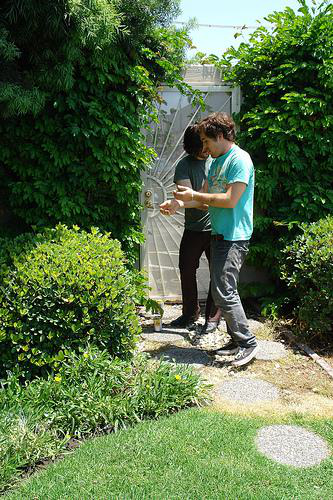

In [ ]:
idx = df.index[0]
iid, _ = idx
capt= df.loc[idx].values[0]

iid2img[iid]

In [ ]:
capt

'Two young guys with shaggy hair look at their hands while hanging out in the yard .'

In [ ]:
prompts = ['guys', 'Two young guys', 'Two young guys with shaggy hair']
image = iid2img[iid]

In [ ]:
import torch

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

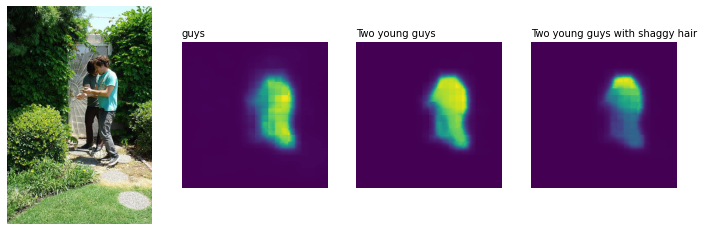

In [ ]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

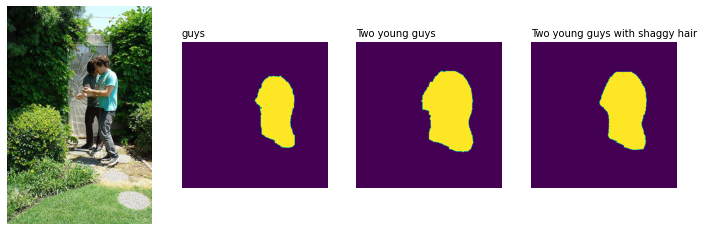

In [ ]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])> .05) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

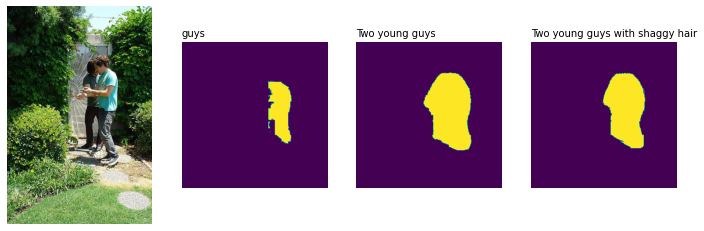

In [ ]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])> .1) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

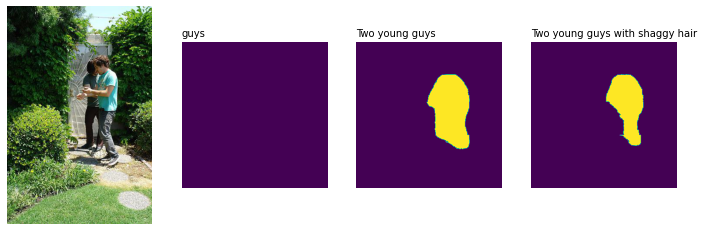

In [ ]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])> .2) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

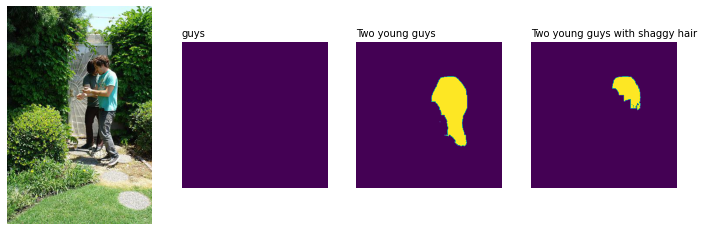

In [ ]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])> .5) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

# Scaler

In [ ]:
torch.sigmoid(preds[0][0]).max(), 

tensor(0.1372)

In [ ]:
from sklearn.preprocessing import StandardScaler
data = [[1, 0], [1, 0], [1, 1], [1, 1]]
scaler = StandardScaler()
print(scaler.fit(data))

print(scaler.mean_)

print(scaler.transform(data))

StandardScaler()
[1.  0.5]
[[ 0. -1.]
 [ 0. -1.]
 [ 0.  1.]
 [ 0.  1.]]


In [ ]:
torch.sigmoid(preds[i][0]).min(), torch.sigmoid(preds[i][0]).max()

(tensor(7.7228e-05), tensor(0.1372))

In [ ]:
torch.sigmoid(preds[i][0])

tensor([[0.0001, 0.0001, 0.0001,  ..., 0.0005, 0.0005, 0.0004],
        [0.0001, 0.0002, 0.0002,  ..., 0.0005, 0.0005, 0.0004],
        [0.0002, 0.0002, 0.0002,  ..., 0.0006, 0.0006, 0.0005],
        ...,
        [0.0002, 0.0002, 0.0002,  ..., 0.0003, 0.0003, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0003, 0.0002, 0.0002],
        [0.0001, 0.0001, 0.0002,  ..., 0.0002, 0.0002, 0.0002]])

In [ ]:
(torch.sigmoid(preds[i][0])-torch.sigmoid(preds[i][0]).min())/(torch.sigmoid(preds[i][0]).max()-torch.sigmoid(preds[i][0]).min())

tensor([[0.0003, 0.0004, 0.0003,  ..., 0.0030, 0.0027, 0.0023],
        [0.0004, 0.0007, 0.0006,  ..., 0.0032, 0.0028, 0.0026],
        [0.0008, 0.0010, 0.0008,  ..., 0.0041, 0.0035, 0.0031],
        ...,
        [0.0008, 0.0010, 0.0009,  ..., 0.0018, 0.0014, 0.0012],
        [0.0007, 0.0008, 0.0008,  ..., 0.0016, 0.0011, 0.0009],
        [0.0005, 0.0005, 0.0006,  ..., 0.0011, 0.0010, 0.0007]])

In [ ]:
from sklearn.preprocessing import StandardScaler,Normalizer
scaler=StandardScaler()
(torch.sigmoid(preds[i][0]) - torch.sigmoid(preds[i][0]).min())
img = scaler.fit_transform(torch.sigmoid(preds[i][0]).reshape(-1,352*352)).reshape(352,352)
print(img.max(), img.min())
scaler=Normalizer()
img = scaler.fit_transform(torch.sigmoid(preds[i][0]).reshape(-1,352*352)).reshape(352,352)
print(img.max(), img.min())

img = (torch.sigmoid(preds[i][0])-torch.sigmoid(preds[i][0]).min())/(torch.sigmoid(preds[i][0]).max()-torch.sigmoid(preds[i][0]).min())
print(img.max(), img.min())

0.0 0.0
0.0124325175 6.996685e-06
tensor(1.) tensor(0.)


### This one looks pretty good

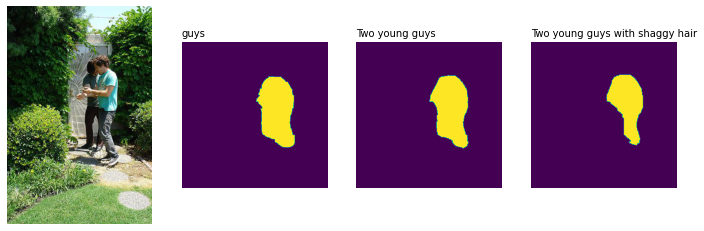

In [ ]:
scaler=Normalizer()
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(scaler.fit_transform(torch.sigmoid(preds[i][0]).reshape(-1,352*352)).reshape(352,352) > .005) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

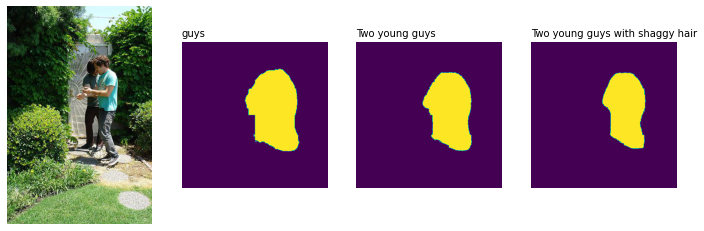

In [ ]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow((torch.sigmoid(preds[i][0])-torch.sigmoid(preds[i][0]).min())/(torch.sigmoid(preds[i][0]).max()-torch.sigmoid(preds[i][0]).min()) > .1) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

This one is bad, it normalize per row of the image, it makes no sense

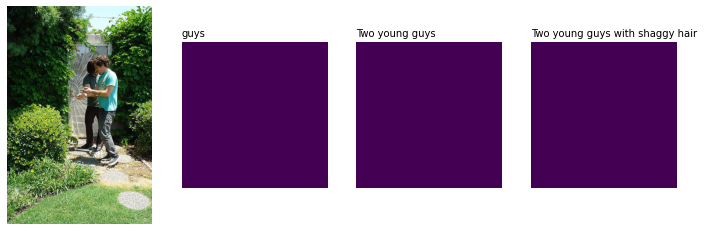

In [ ]:
scaler=StandardScaler()
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(scaler.fit_transform(torch.sigmoid(preds[i][0]).reshape(-1,352*352)).reshape(352,352) > .0001) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

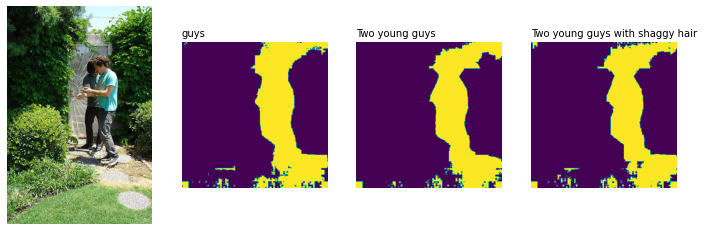

In [ ]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(scaler.fit_transform(torch.sigmoid(preds[i][0]))> .05) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

In [ ]:
scaler.fit_transform(torch.sigmoid(preds[i][0]).reshape(352*352,-1)).reshape(352,352).shape

(352, 352)

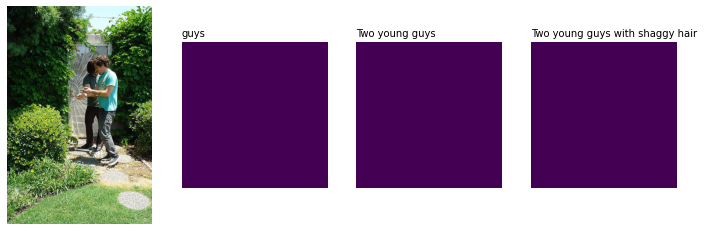

In [ ]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow( scaler.fit_transform(torch.sigmoid(preds[i][0]).reshape(352*352,-1)).reshape(352,352) > .01) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];